In [1]:
import sys
print(sys.executable)

/opt/homebrew/Caskroom/miniconda/base/bin/python


In [1]:
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from pickle import dump, load

from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern

In [2]:
# Define function to load images from a specific folder
def load_images_from_folder(folder):
    X, y = [], []
    for subdir, dirs, files in os.walk(folder):
        label = os.path.basename(subdir)
        for file in tqdm(files, desc=f"Loading {label}"):
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                try:
                    # Load, resize, flatten to (64x64) → (4096,)
                    image = Image.open(img_path).resize((48, 48))
                    X.append(np.array(image).ravel())
                    y.append(label)
                except Exception as e:
                    print(f"Failed to load {img_path}: {e}")
    
    return np.array(X), np.array(y)

# Define paths for train and validation folders
train_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images/train'
val_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images/validation'

# Load training data
X_train, y_train = load_images_from_folder(train_folder)
X_val, y_val = load_images_from_folder(val_folder)

print(f"Training samples: {len(X_train)} | Validation samples: {len(X_val)}")

# (Optional) Save datasets as a pickle file
dataset_file = "dataset_dump.pkl"
with open(dataset_file, "wb") as f:
    dump((X_train, y_train, X_val, y_val), f, protocol=5)

Loading disgust: 100%|██████████| 436/436 [00:00<00:00, 6312.17it/s]
Loading validation: 0it [00:00, ?it/s]
Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 7606.94it/s]


Training samples: 28821 | Validation samples: 7066


In [ ]:

# def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
#     hog_features = []
#     for img in images:
#         # Reshape flat images back to 2D
#         img_reshaped = img.reshape(48, 48)
#         features = hog(
#             img_reshaped,
#             pixels_per_cell=pixels_per_cell,
#             cells_per_block=cells_per_block,
#             orientations=9,
#             block_norm='L2-Hys'
#         )
#         hog_features.append(features)
#     return np.array(hog_features)

# def extract_lbp_features(images, radius=1, n_points=8):
#     lbp_features = []
#     for img in images:
#         img_reshaped = img.reshape(48, 48)
#         lbp = local_binary_pattern(
#             img_reshaped,
#             P=n_points * radius,
#             R=radius,
#             method='uniform'
#         )
#         # Count histogram of LBP patterns
#         lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points * radius + 3), range=(0, n_points * radius + 2))
#         lbp_hist = lbp_hist.astype("float")
#         lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize histogram
#         lbp_features.append(lbp_hist)
#     return np.array(lbp_features)

# X_train_hog = extract_hog_features(X_train)
# X_test_hog = extract_hog_features(X_val)

# X_train_lbp = extract_lbp_features(X_train)
# X_test_lbp = extract_lbp_features(X_val)

# # Combine original pixel data with HOG & LBP features
# X_train_combined = np.hstack([X_train, X_train_hog, X_train_lbp])
# X_test_combined = np.hstack([X_val, X_test_hog, X_test_lbp])

# print(f"Combined feature shape (train): {X_train_combined.shape}")
# print(f"Combined feature shape (test): {X_test_combined.shape}")

Combined feature shape (train): (28821, 3214)
Combined feature shape (test): (7066, 3214)


In [16]:
# with open("dataset_dump.pkl", "rb") as f:
#     X_original,X,y = load(f)

In [ ]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train
y_train

X_test = np.array(X_val)
y_test = np.array(y_val)

X_test
y_test

array(['happy', 'happy', 'happy', ..., 'disgust', 'disgust', 'disgust'],
      dtype='<U8')

In [18]:
def enhanced_preprocessing_pipeline(X_train, y_train, X_test, y_test, save_file_to=None):
    # Step 1: Encode labels first (needed for class-aware operations)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Step 2: Check class distribution
    unique, counts = np.unique(y_train_encoded, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("Original class distribution:", class_dist)
    
    # Step 3: Normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # Step 4: Apply enhanced class-aware augmentation with SMOTE and image augmentation
    img_size = int(np.sqrt(X_train.shape[1]))
    augmented_data = []
    augmented_labels = []
    
    if img_size * img_size == X_train.shape[1]:
        # Reshape to image format
        X_train_img = X_train.reshape(-1, img_size, img_size, 1)
        
        # Find minority classes - classes with fewer samples
        max_class_count = max(counts)
        minority_classes = [i for i, count in enumerate(counts) if count < max_class_count]
        
        print(f"Applying targeted augmentation to minority classes: {minority_classes}")
        
        # Enhanced image data generator with more transformations
        datagen = ImageDataGenerator(
            rotation_range=20,        # Increased rotation
            width_shift_range=0.5,   # Increased shift
            height_shift_range=0.5,  # Increased shift
            zoom_range=0.5,          # Increased zoom
            horizontal_flip=True, 
            brightness_range=[0.5, 2.0],  # Brightness variation
            channel_shift_range=0.5,      # Color channel shifts
            fill_mode='nearest'
        )
        
        # Track augmented counts per class for balancing
        aug_counts = {cls: 0 for cls in unique}
        
        # Target 100% of majority class (more aggressive balancing)
        target_count = max_class_count
        
        for i in range(len(X_train_img)):
            img = X_train_img[i:i+1]
            label = y_train_encoded[i]
            
            # Skip if this class already has enough samples
            if label not in minority_classes or aug_counts[label] >= (target_count - counts[label]):
                continue
                
            # More augmentation for minority classes
            aug_iter = datagen.flow(img, np.array([label]), batch_size=1)
            
            # Calculate how many augmentations needed per image
            remaining_needed = target_count - counts[label] - aug_counts[label]
            samples_left = sum(1 for j in range(i, len(X_train_img)) if y_train_encoded[j] == label)
            aug_per_img = min(5, max(1, int(np.ceil(remaining_needed / max(1, samples_left)))))
            
            for j in range(aug_per_img):
                augmented_img, augmented_label = next(aug_iter)
                augmented_data.append(augmented_img[0])
                augmented_labels.append(augmented_label[0])
                aug_counts[label] += 1
                
                # Break if we've reached our target
                if aug_counts[label] >= (target_count - counts[label]):
                    break
            
            # Print progress occasionally
            if i % 1000 == 0:
                print(f"Processed {i}/{len(X_train_img)} images, augmented totals: {aug_counts}")
        
        if augmented_data:
            # Convert augmented data to arrays
            augmented_data = np.array(augmented_data)
            augmented_labels = np.array(augmented_labels)
            
            # Reshape back to flat
            augmented_data_flat = augmented_data.reshape(augmented_data.shape[0], -1)
            
            # Combine original and augmented
            X_train_combined = np.vstack([X_train, augmented_data_flat])
            y_train_encoded_combined = np.concatenate([y_train_encoded, augmented_labels])
            
            # Check new class distribution after image augmentation
            unique_after_img, counts_after_img = np.unique(y_train_encoded_combined, return_counts=True)
            print("Class distribution after image augmentation:", dict(zip(unique_after_img, counts_after_img)))
            
            # Apply SMOTE for final balancing (helps with variance)
            print("Applying SMOTE to further balance classes...")
            smote = SMOTE(random_state=42, k_neighbors=min(5, min(counts)-1))
            try:
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train_encoded_combined)
                unique_final, counts_final = np.unique(y_train_resampled, return_counts=True)
                print("Final class distribution after SMOTE:", dict(zip(unique_final, counts_final)))
                
                # Use the SMOTE balanced dataset
                X_train = X_train_resampled
                y_train_encoded = y_train_resampled
            except ValueError as e:
                print(f"SMOTE failed, using image augmentation only. Error: {e}")
                X_train = X_train_combined
                y_train_encoded = y_train_encoded_combined
    else:
        # If we can't reshape to images, use SMOTE/ADASYN directly
        print("Cannot reshape to images. Using SMOTE directly on flattened data.")
        try:
            # Attempt with SMOTE first
            smote = SMOTE(random_state=42)
            X_train, y_train_encoded = smote.fit_resample(X_train, y_train_encoded)
        except ValueError:
            try:
                # Fall back to ADASYN if SMOTE fails
                print("SMOTE failed, trying ADASYN...")
                adasyn = ADASYN(random_state=42)
                X_train, y_train_encoded = adasyn.fit_resample(X_train, y_train_encoded)
            except ValueError as e:
                print(f"ADASYN also failed: {e}. Proceeding with original imbalanced data.")
                
        unique_after, counts_after = np.unique(y_train_encoded, return_counts=True)
        print("Class distribution after resampling:", dict(zip(unique_after, counts_after)))
    
    # Step 5: Apply PCA with higher variance retention
    pca = PCA(n_components=0.99, whiten=True, random_state=42)  # Increased from 0.95 to 0.98
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    print(f"PCA components: {X_train_reduced.shape[1]}")
    
    # Step 6: Standardize after dimensionality reduction
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_reduced)
    X_test_scaled = scaler.transform(X_test_reduced)
    
    # Step 7: Feature selection based on importance
    selector = SelectKBest(f_classif, k=min(150, X_train_scaled.shape[1]))
    X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
    X_test_selected = selector.transform(X_test_scaled)
    
    print("Final shapes:")
    print(f"Training: {X_train_selected.shape}, Validation: {X_test_selected.shape}")
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_train_selected, y_train_encoded, X_test_selected, y_test_encoded, 
                  label_encoder, scaler, pca, selector), f, protocol=5)
    
    return X_train_selected, y_train_encoded, X_test_selected, y_test_encoded, label_encoder
# Preprocess data
preprocessed_file = "improved_preprocessed_data.pkl"
X_train_selected, y_train_encoded, X_test_selected, y_test_encoded, label_encoder = enhanced_preprocessing_pipeline(X_train, y_train, X_test, y_test, save_file_to=preprocessed_file)


Original class distribution: {0: 3993, 1: 436, 2: 4103, 3: 7164, 4: 4982, 5: 4938, 6: 3205}
Cannot reshape to images. Using SMOTE directly on flattened data.
Class distribution after resampling: {0: 7164, 1: 7164, 2: 7164, 3: 7164, 4: 7164, 5: 7164, 6: 7164}
PCA components: 830
Final shapes:
Training: (50148, 150), Validation: (7066, 150)


In [19]:
# X_train_scaled[0]
# X_train_selected[0]
X_train_combined[0]

array([1.83000000e+02, 1.84000000e+02, 1.83000000e+02, ...,
       5.03472222e-02, 5.29513889e-02, 8.85416667e-02])

In [20]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, label_encoder):
    from sklearn.ensemble import RandomForestClassifier
    
    param_grid = {
        'min_samples_leaf': [2, 4, 8],
        'n_estimators': [300, 400], 
        'max_depth': [None, 20, 30], 
        'min_samples_split': [5, 10], 
        'class_weight': ['balanced']
    }

    best_combination = None
    best_accuracy = 0
    
    # Convert class names to strings if they're not already
    class_names = [str(name) for name in label_encoder.classes_]

    all_combinations = list(ParameterGrid(param_grid))
    print(f"Total combinations to evaluate: {len(all_combinations)}")
    
    for i, combination in enumerate(all_combinations):
        print(f"\nCombination {i+1}/{len(all_combinations)}:", combination)
        rf_model = RandomForestClassifier(**combination, random_state=42)
        rf_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf_model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination
    
    # Print the best combination
    print("\nBest Combination:", best_combination)
    print(f"Best Accuracy: {best_accuracy:.2f}")

    # Train the best model on the entire training set
    best_model = RandomForestClassifier(**best_combination, random_state=42)
    best_model.fit(X_train, y_train)

    # Save the best model
    with open("rf_model_standardscaler_gridsearch_pca_dump.pkl", "wb") as f:
        dump(best_model, f, protocol=5)
    print("Best model saved successfully!")

    return best_model, best_combination

best_model, best_combination = train_and_evaluate_rf(X_train_selected, y_train_encoded, X_test_selected, y_test_encoded, label_encoder)

Total combinations to evaluate: 36

Combination 1/36: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.18      0.25       960
     disgust       0.86      0.39      0.53       111
        fear       0.41      0.27      0.33      1018
       happy       0.43      0.68      0.53      1825
     neutral       0.37      0.30      0.33      1216
         sad       0.32      0.33      0.32      1139
    surprise       0.60      0.59      0.60       797

    accuracy                           0.42      7066
   macro avg       0.48      0.39      0.41      7066
weighted avg       0.42      0.42      0.40      7066


Combination 2/36: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}


KeyboardInterrupt: 

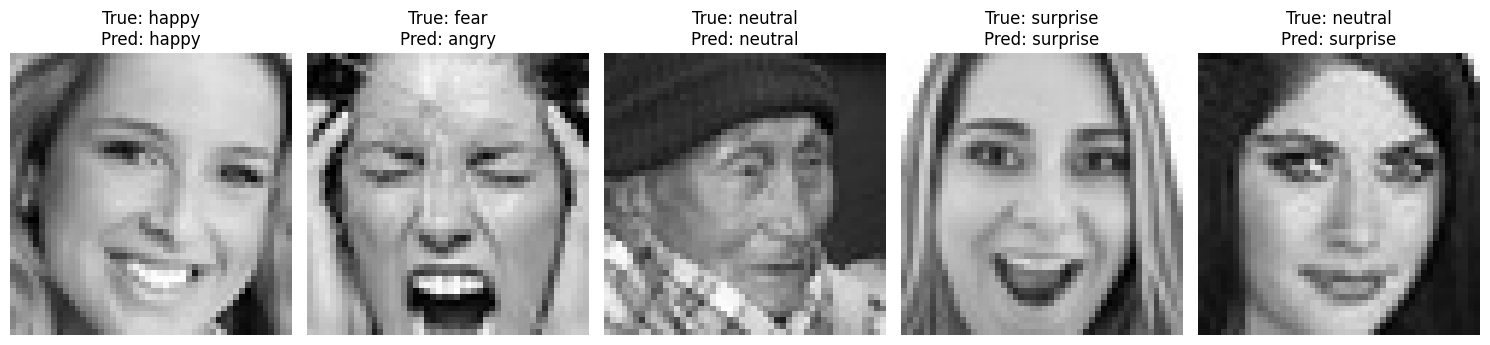

In [ ]:
def visualize_predictions(best_model, X_test_selected, y_test_encoded, label_encoder, X_test_original):
    # Make predictions on the transformed/selected test data
    y_pred = best_model.predict(X_test_selected)
    
    # Choose random indices to visualize
    random_indices = np.random.randint(0, len(y_test_encoded), 5)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, 5, i+1)
        
        # Reshape the original image (48x48 from your resize operation)
        original_image = X_test_original[idx].reshape(48, 48)
        
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test_encoded[idx]])[0]}\n"
                  f"Pred: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with the proper variables
# You need the original test images before preprocessing
X_test_original = X_test * 255.0  # Convert back from normalized values if necessary

visualize_predictions(best_model, X_test_selected, y_test_encoded, label_encoder, X_test_original)